In [1]:

import cartopy.crs as ccrs
import cartopy.feature as cf
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import glob
import dask

import easygems.healpix as egh

savedir = '/home/users/train045/Documents/WCRP25_hackathon/figs/'

/home/users/train045/miniforge3/envs/wcrp_hackathon/lib/python3.12/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
# len(glob.glob(f'/work/scratch-nopw2/train045/wmax_zoom11/*'))

### global view

In [35]:
def grab_results(zoom):
    files = glob.glob(f'/work/scratch-nopw2/train045/wmax_zoom{zoom}/time_*.zarr')
    
    li = []
    for f in files:
        li.append(xr.open_zarr(f).wa)
    ds = xr.concat(li, dim='time')

    return ds

zoom = 6

ds6 = grab_results(zoom)

In [36]:
cat = intake.open_catalog('https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml')['online']
global_ = cat['icon_d3hp003aug'](zoom=zoom, time='PT15M').to_dask().pipe(egh.attach_coords).ts

/home/users/train045/miniforge3/envs/wcrp_hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [37]:
# get on global grid
da = xr.Dataset(coords=global_.coords)
da['tropics_mask'] = global_.cell.isin(ds6.cell)
da['cell'] = da.cell
da = xr.merge((da, ds6), )

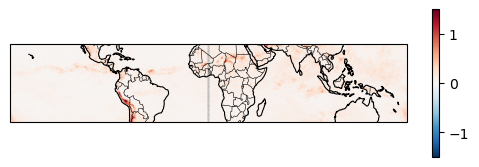

In [38]:
# view map

di = {6: (0,2),
    9: (0,25),
    11: (0,55)}

projection = ccrs.Robinson(central_longitude=0)
fig, ax = plt.subplots(subplot_kw={'projection': projection}, )
# ax.set_extent([115,155,-10,10], crs=ccrs.PlateCarree()) # Warm Pool
ax.set_extent([0,360,-30,30], crs=ccrs.PlateCarree())

d = da.wa.max('time')
p = egh.healpix_show(d, ax=ax, cmap='RdBu_r', vmin=-di[zoom][1] * 0.75, vmax=di[zoom][1] * 0.75)

fig.colorbar(p, shrink=.4)
# ax.set_title(d.time.dt.strftime('%Y/%m/%d %H:%M (UTC)').item())

ax.add_feature(cf.COASTLINE, linewidth=0.8)
ax.add_feature(cf.BORDERS, linewidth=0.4)

# tstr = d.time.dt.strftime('%Y%m%dT%H%M').item()
fig.savefig(savedir + f'map_max_updrafts_tropics_zoom{zoom}.jpg', dpi=100, bbox_inches='tight')

### compare convective zones

In [2]:
domain_extents = {"amazon": (280, 325, -15, 10),
                  "congo": (0, 35, -12, 24),
                  "warm pool": (90, 160, -15, 15),}

def cells_of_domain(ds, domain_name):
    lon_min, lon_max, lat_min, lat_max = domain_extents[domain_name]
    cells = ds.cell
    c1 = cells.where(ds.lon>lon_min).where(ds.lon<lon_max).where(ds.lat>lat_min).where(ds.lat<lat_max)
    return c1.dropna('cell')

In [5]:
cat = intake.open_catalog('https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml')['online']

In [25]:
# zoom ranges
di = {6: (0,2),
      9: (0,25),
      11: (0,55)}

def grab_results(zoom):
    files = glob.glob(f'/work/scratch-nopw2/train045/wmax_zoom{zoom}/time_*.zarr')
    global_ = cat['icon_d3hp003aug'](zoom=zoom, time='PT15M').to_dask().pipe(egh.attach_coords).ts
    
    region_data = {r:[] for r in domain_extents.keys()}
    for f in files:
        d = xr.open_zarr(f).wa
        
        # select regions
        for region in domain_extents.keys():
            cells = cells_of_domain(global_, region)
            reg_data = d.sel(cell=cells).data.flatten()
            region_data[region].append(reg_data)

    # compute hist
    hist_data = {}
    for region in domain_extents.keys():
        li = region_data[region]
        da = dask.array.concatenate(li)
        hist, bin_edges = dask.array.histogram(da, bins=20, range=di[zoom])
        hist_data[region] = (hist, bin_edges)

    return hist_data

zoom = 6
hist_data = grab_results(zoom)

/home/users/train045/miniforge3/envs/wcrp_hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


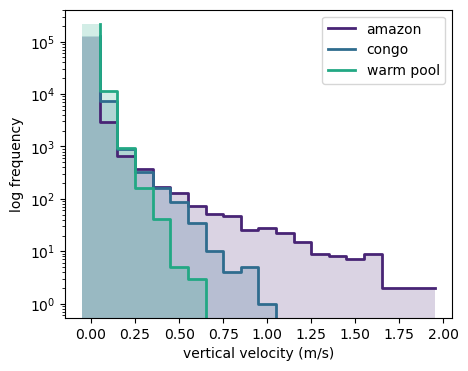

In [26]:
# plot

fig, ax = plt.subplots(1,1, figsize=(5,4))
N = 4
cmap = plt.get_cmap('viridis')

for i, region in enumerate(domain_extents.keys()):
    hist, bin_edges = hist_data[region]
    hist = hist.compute()
    ax.step(bin_edges[:-1]+.5*np.diff(bin_edges), hist, color=cmap(i/N+.1), label=region, lw=2)
    ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), color=cmap(i/N+.1), alpha=.2, lw=2)
    ax.set_title('')
    ax.set_xlabel('vertical velocity (m/s)')
    ax.set_yscale('log')
    ax.set_ylabel('log frequency')

ax.legend()
fig.savefig(savedir + f'updrafts_hist_compare_regions_filled-zoom{zoom}.jpg')


In [14]:
# # subset regions then plot histograms

# di = {6: (0,2),
#     9: (0,25),
#     11: (0,55)}

# fig, ax = plt.subplots(1,1, figsize=(5,4))
# N = 4
# cmap = plt.get_cmap('viridis')

# for i, region in enumerate(domain_extents.keys()):
#     # grab region
#     cells = cells_of_domain(global_, region)
#     reg_data = ds6.sel(cell=cells)
#     reg_data.plot.hist(ax=ax, bins=20, range=di[zoom], color=cmap(i/N+.1), label=region, histtype='step', lw=2)
#     ax.set_title('')
#     ax.set_xlabel('vertical velocity (m/s)')
#     ax.set_yscale('log')
#     ax.set_ylabel('log frequency')

# ax.legend()
# fig.savefig(savedir + f'updrafts_hist_compare_regions-zoom{zoom}.jpg')


### make histogram

In [5]:
def make_hist(zoom):
    files = glob.glob(f'/work/scratch-nopw2/train045/wmax_zoom{zoom}/time_*.zarr')
    
    li = []
    for f in files:
        li.append(xr.open_zarr(f).wa.data.flatten())
    da = dask.array.concatenate(li)
    
    # compute hist
    hist, bin_edges = dask.array.histogram(da, bins=20, range=(da.min(), da.max()))
    hist = hist.compute()
    bin_edges = bin_edges.compute()

    return hist, bin_edges

In [6]:
data = {}
zoom = 9
data[zoom] = make_hist(zoom)

In [7]:
zoom = 11
data[zoom] = make_hist(zoom)

In [9]:
zoom = 6
data[zoom] = make_hist(zoom)

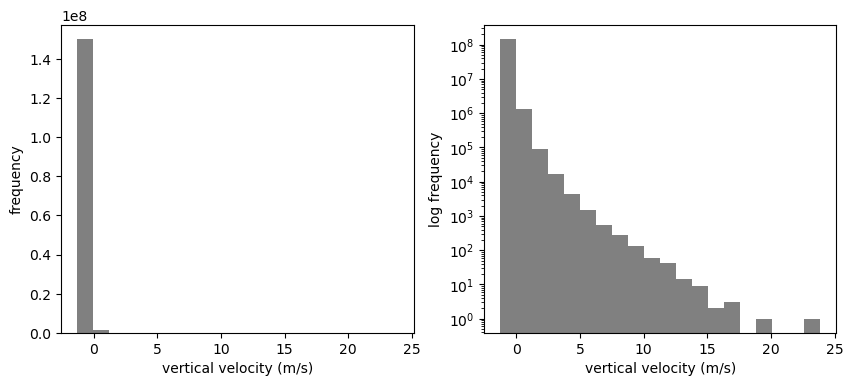

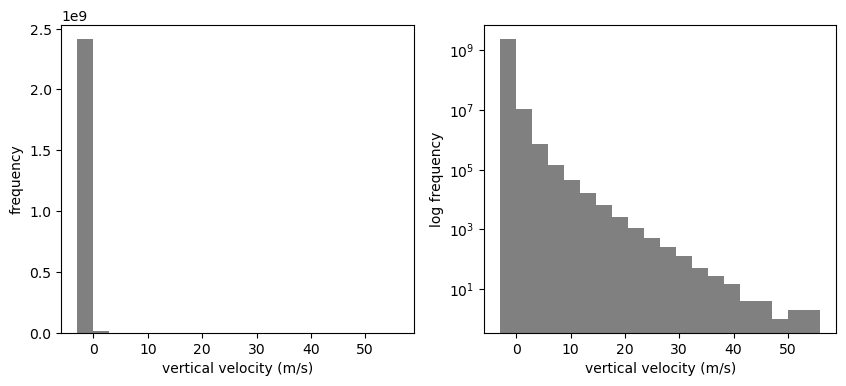

In [8]:
# plot distribution

def plot_w_hist(hist, bin_edges, zoom):

    fig, axs = plt.subplots(1,2, figsize=(10,4))

    for ax in axs:
        ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), color='grey')
        ax.set_title('')
        ax.set_ylabel('frequency')
        ax.set_xlabel('vertical velocity (m/s)')

    axs[1].set_yscale('log')
    axs[1].set_ylabel('log frequency')

    fig.savefig(savedir + f'updrafts_hist_tropics-zoom{zoom}.jpg')

plot_w_hist(*data[9], 9)
plot_w_hist(*data[11], 11)

In [29]:
# compare resolutions

In [1]:
# compare

fig, axs = plt.subplots(1,3, figsize=(15,4))

def plot_ax(ax, hist, bin_edges):
    ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), color='grey')
    ax.set_title('')
    ax.set_xlabel('vertical velocity (m/s)')
    ax.set_yscale('log')
    ax.set_ylabel('log frequency')
    return ax

zooms = (6,9,11) # 100,10,2.5 km


for i,ax in enumerate(axs):
    zoom = zooms[i]
    d = data[zoom]
    ax = plot_ax(ax, *d)
    ax.set_title(f'zoom={zoom}')

fig.savefig(savedir + f'updrafts_hist_tropics-res_comparison.jpg')

NameError: name 'plt' is not defined

In [ ]:
# characterise PDFs and view globally...?